# <center>Final Report on the Project  
# <center>[Safe Trade: Stock Prediction](https://github.com/breindy/SafeTrade)
Shofiqur Rahman<br>
Bashir Ahamed<br>
Michelle Uy<br>
Thierno Diallo<br><br>
Grant Long<br>
CSC.59970<br>
December 10, 2018

For the purpose of creating the model, we had to spend a lot of time on just data gathering and cleaning. Since these finance data could not be found anywhere ready as to be used in modelling, we had to query into different API's to get the data and have them ready for analysis. Most of the data came from [IEX API](https://iextrading.com/developer/docs/), but the stock exchange index data came from [Yahoo Finance](https://finance.yahoo.com/quote/%5EIXIC/history?ltr=1). 
We wrote a separate [python script](AggregateData.py) to fetch the necessary data. We had the data cleaned and ready to be used in model building process by the same script. The script basically makes request to the IEX API to fetch all the company symbols. For each symbol that are presently in transaction in the IEX Exchange, the script makes subsequent calls to fetch the whole year eps, dividend, and all other features value and add them to the main dataframe in iterations one by one. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

AllDF = pd.read_csv('AllStockData.csv')
AllDF.head()

,Unnamed: 0,date,company,symbol,dividend,eps,nasdaqIndex,numberOfShare,pe,price,profitPerShare,revenuePerShare
0,0,2017-11-28,Zoetis Inc. Class A,ZTS,0.105,0.76,NaN,5.963746e+08,70.9670,70.9670,5.144417,3
1,1,2017-11-29,Zoetis Inc. Class A,ZTS,0.105,0.76,NaN,5.945424e+08,71.1857,71.1857,5.160271,3
2,2,2017-11-30,Zoetis Inc. Class A,ZTS,0.105,0.76,NaN,5.889504e+08,71.8616,71.8616,5.209267,3
3,3,2017-12-01,Zoetis Inc. Class A,ZTS,0.105,0.76,NaN,5.888685e+08,71.8716,71.8716,5.209992,3
4,4,2017-12-04,Zoetis Inc. Class A,ZTS,0.105,0.76,NaN,5.994824e+08,70.5991,70.5991,5.117748,3


In [2]:
print(AllDF.shape)
print(AllDF.isna().sum())
AllDF.isnull().values.any()

(554185, 12)
Unnamed: 0             0
date                   0
company                0
symbol                 0
dividend               0
eps                    0
nasdaqIndex        19225
numberOfShare          0
pe                     0
price                  0
profitPerShare         0
revenuePerShare        0
dtype: int64


True

In [3]:
# Replacing infinite values with NaN and then
# Cleaning out the null or nan values
AllDF.replace([np.inf, -np.inf], np.nan)
AllDF.dropna()
# Dropping the 'NaN' rows that is read as string
AllDF = AllDF[~AllDF['nasdaqIndex'].isin(['NaN'])]

print(AllDF.shape)
print(AllDF.isna().sum())
AllDF.isnull().values.any()

(534960, 12)
Unnamed: 0         0
date               0
company            0
symbol             0
dividend           0
eps                0
nasdaqIndex        0
numberOfShare      0
pe                 0
price              0
profitPerShare     0
revenuePerShare    0
dtype: int64


False

Even after cleaning the whole dataframe in the the manner showed above, we still face with some unresolved anomalies like infinite values, NaN values for some columns that could not be resolved in any meaningful way. We tried working on the model using all the data rows available(about half a million), but those anomalies hindered progress. Instead, we manually checked for some companies that carries valid data and a created a dataframe with only those valid rows.

In [4]:
### Taking only the desired company date
df = AllDF.loc[AllDF['symbol'].isin(['AAL', 'AAPL', 'ATVI', 'BAC', 'BAM', 'CMCSA', 'CSCO', 'CVX', 'DAL', 'DCP', 'EARN', 'EBSB', 'F', 'FOXA', 'GBCI', 'HAYN', 'INTC', 'KCAP', 'JBLU', 'JNJ', 'JPM', 'LAND', 'MCD', 'MSFT', 'NVDA', 'OFC', 'PFE', 'QCOM', 'RAVN', 'RELL', 'SQM', 'SPR', 'T', 'TEVA', 'UNH', 'VZ', 'WFC', 'WMT', 'XOM', 'Y', 'YUM', 'ZEUS', 'ZBRA'])]
#df = AllDF.loc[AllDF['symbol'].isin(['AAPL'])]
df.shape

(10250, 12)

In [5]:
print(df.shape)
print(df.isna().sum())
df.isnull().values.any()

(10250, 12)
Unnamed: 0         0
date               0
company            0
symbol             0
dividend           0
eps                0
nasdaqIndex        0
numberOfShare      0
pe                 0
price              0
profitPerShare     0
revenuePerShare    0
dtype: int64


False

In [31]:
### Cleaning the dataframe df to have only features that have numeric values as well as 
# dividing the DataFrame in X(Features) and Y(Target)
X = df[['date', 'dividend', 'eps', 'nasdaqIndex', 'numberOfShare', 'pe', 'profitPerShare', 'revenuePerShare']].copy()
X['date'] = X['date'].str.replace("-","").astype(int)
Y = df.price
print(Y.head(3))
X.head(3)

786    21.4096
787    20.9613
788    21.6288
Name: price, dtype: float64


,date,dividend,eps,nasdaqIndex,numberOfShare,pe,profitPerShare,revenuePerShare
786,20171211,0.02,0.835,6.87508,8.972450e+06,21.4096,20.483815,0
787,20171212,0.02,0.835,6.86232,9.164344e+06,20.9613,20.054900,0
788,20171213,0.02,0.835,6.87580,8.881517e+06,21.6288,20.693536,0


In [32]:
### Normalizing every feature column### Normalizing every feature column
# Have not used this function though
def normalize(x):
    z=x
    if(x.min() < x.max()):
        z = (x - x.min()) / (x.max() - x.min())
    return z

#for x in X:
#    X[x] = normalize(X[x])
#X.head(5)

To test the performance of different models, we tested the data on various model. 

In [34]:
# Splitting the dataset into train and test so that we have a holdout set to test our model's performance
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# Instantiate dt: min_samples_leaf tells the model to keep at least 10% data for each leaf
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.1, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))


Test set RMSE of dt: 54.68


As we can see from the RMSE valaue, the prediction performed very poorly even by a more sophisticated tool than a linear regressor. The decision tree regressor model works by creating decision tree to capture more sophisticated data pattern that a linear regressor model might miss. Still we have not got a desired performance. 
We trained Random Forest Regressor on the same dataset, but got a much much better performance. Random forest is an ensemble method that uses decision tree as base estimator. But unlike the Decision Tree Regressor to use only one model, it creates n_estimators. Each estimator is trained on a different bootstrap sample having the same size as the training set. After the training, when an example is fed to the model, each of the estimators outputs a prediction. The final prediction is the average of all the labels predicted by the estimators. 

Test set RMSE of rf: 0.16


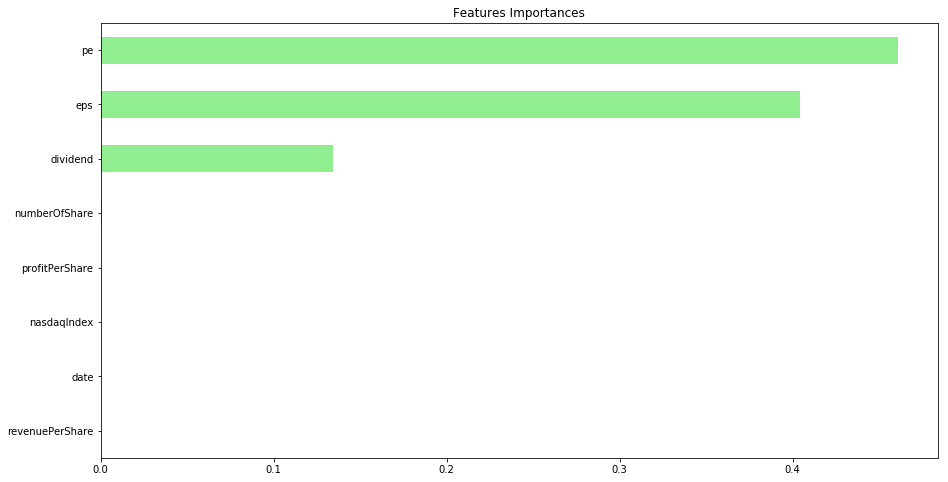

In [36]:
### To see what features contribute the most toward price determination

# Instantiate the datamodel rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)

# Fit rf to the training set    
rf.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

Populating the interactive namespace from numpy and matplotlib


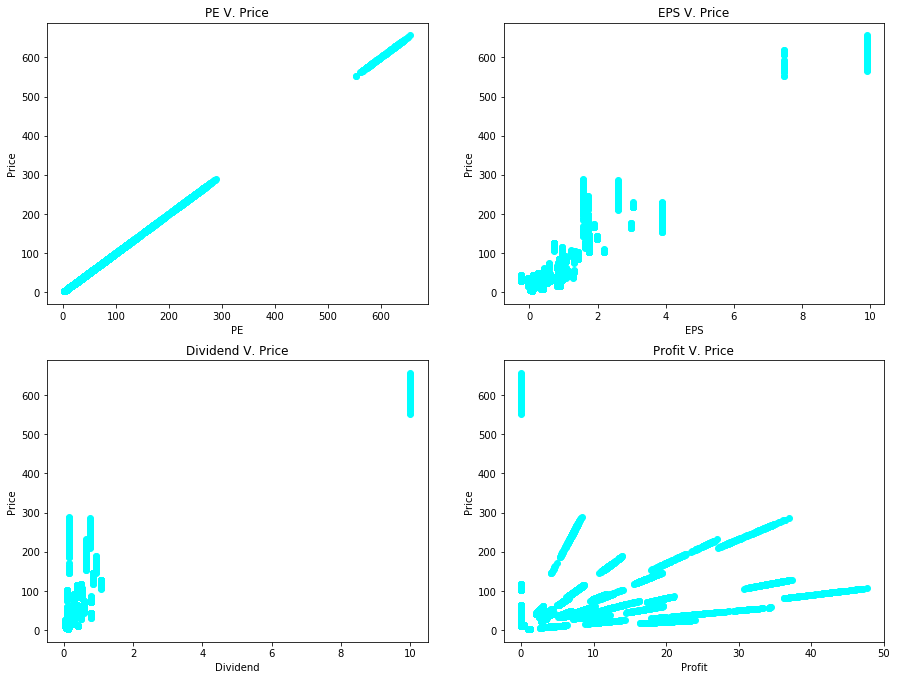

In [37]:
# Visualizig correlation between stock price and pe
# This will set all figures in the document (unless otherwise specified) to be of the size (15, 8)
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
# T adjust the display of each subplot
plt.subplots_adjust(bottom=None, top=1.2)

plt.subplot(2, 2, 1)
plt.scatter(df.pe, df.price, color='cyan')
plt.title("PE V. Price")
plt.xlabel('PE')
plt.ylabel('Price')

plt.subplot(2, 2, 2)
plt.scatter(df.eps, df.price, color='cyan')
plt.title("EPS V. Price")
plt.xlabel('EPS')
plt.ylabel('Price')

plt.subplot(2, 2, 3)
plt.scatter(df.dividend, df.price, color='cyan')
plt.title("Dividend V. Price")
plt.xlabel('Dividend')
plt.ylabel('Price')

plt.subplot(2, 2, 4)
plt.scatter(df.profitPerShare, df.price, color='cyan')
plt.title("Profit V. Price")
plt.xlabel('Profit')
plt.ylabel('Price')

plt.show()


As we can see from the figures above, pe has the strongest positive correlation with price. Though the other attributes also show a positive correlation, still they behave differently with different copany. We also see that the graph obtained from the correlation between ProfitPerShare and price is very significant though the Random Forest Regressor failed to capture that or probably it is so varied that the model chose to ignore it by not giving it much weight. 

We also tried to see how the model performs when trained with all data as opposed to trained only on its own company data. So again, we used the same Decision Tree Regressor model to build our individual company model and predicted on hold out data set. The prediction performance is displayed in the graph with actual price.


426565    20180320
426747    20181207
426728    20181108
426659    20180802
426589    20180424
426722    20181031
426556    20180307
426732    20181114
426678    20180829
426502    20171215
426740    20181127
426686    20180911
426614    20180530
426680    20180831
426625    20180614
426576    20180405
426682    20180905
426549    20180226
426525    20180122
426571    20180328
426723    20181101
426532    20180131
426593    20180430
426684    20180907
426618    20180605
426617    20180604
426744    20181203
426737    20181121
426536    20180206
426714    20181019
            ...   
426608    20180521
426533    20180201
426509    20171227
426527    20180124
426498    20171211
426726    20181106
426583    20180416
426610    20180523
426646    20180716
426669    20180816
426615    20180531
426616    20180601
426526    20180123
426514    20180104
426628    20180619
426679    20180830
426648    20180718
426670    20180817
426687    20180912
426545    20180220
426695    20180924
426538    20

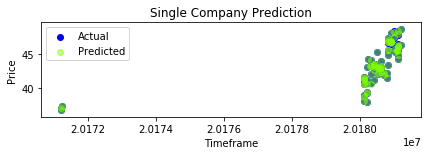

In [49]:
# Building model with CSCO data only
cscoDF = AllDF.loc[AllDF['symbol'].isin(['CSCO'])]
cscoX = cscoDF[['date', 'dividend', 'eps', 'nasdaqIndex', 'numberOfShare', 'pe', 'profitPerShare', 'revenuePerShare']].copy()
# Converting date to int to be ready to be used in the model
cscoX['date'] = cscoX['date'].str.replace("-","").astype(int)
cscoY = cscoDF.price
cscoX_train, cscoX_test, cscoy_train, cscoy_test = train_test_split(cscoX, cscoY, test_size=0.3, random_state=1)
cscoRF = RandomForestRegressor(n_estimators=25, random_state=2)
cscoRF.fit(cscoX_train, cscoy_train)
cscoy_pred = cscoRF.predict(cscoX_test)
ally_pred = rf.predict(cscoX_test)
plt.subplot(4, 2, 1)
plt.scatter(cscoX_test['date'], cscoy_test, color='blue', label='Actual')
plt.scatter(cscoX_test['date'], cscoy_pred, color='chartreuse', label='Predicted', alpha=0.5)
plt.title("Single Company Prediction")
plt.xlabel('Timeframe')
plt.ylabel('Price')
plt.legend(loc='upper left');
#plt.axis([20180, 30180, 0, 50])
print(cscoX_test['date'])


msftDF = AllDF.loc[AllDF['symbol'].isin(['MSFT'])]
dalDF = AllDF.loc[AllDF['symbol'].isin(['DAL'])]
dalDF = AllDF.loc[AllDF['symbol'].isin(['CVX'])]



In [ ]:
### R-Squared for Linear Regression; to check the model performance statistically
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(rf, X, Y, cv=10)
print(cv_results)
np.mean(cv_results)

# Challenges
First of all, to come up with valid features was a challenge. What features we feed into the model to train on. To ease the process of investing, we faced with a challenge of learning finance. Having a finance major in our team could have been very fruitful since we are not so educated with all those finance terms. 
Second, the data was not ready anywhere. Though, we got most of our data from [IEX API](https://iextrading.com/developer/docs/), it did not come in a form to be used in the data model. We had to check for missing values, values not in proper format etc. 
Also, stock market is very sensitive to rumors or even tweets from Trump. The market goes up and down from a single tweet by Trump. We could not figure out how do we train model on rumors.

# Further Considerations
We know stocks of same type like pharmacuticals or tech industry often behave in a similar way. So, building a model that is trained to classify a certain company into a category will be beneficial to prediction.
There are some other nonnumeric parameters, we know from our little knowledge in finance, that oftentimes determine stock price like earning report date, dividend record date, or even the proximity to the next election. We might want to add these features to the model training as countdown of time to these event as the closer those events are more sensitive the stocks are. 
Also the prediction model need to consider the timeframe for which the prediction is valid. Unlike other prediction model, like an apartment price, we know the current price of stock to the exact point. What we want to be able is to predict something for the future for which we might not have the required feature values. Thats why coming up with some kind of rating for each stock instead of exact price will be more reasonable. 